In [2]:

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import sys


Using TensorFlow backend.


In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

In [4]:
batch_size = 128
num_classes = 10
epochs = 50


In [5]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
iterations = np.ceil((x_train.shape[0]*epochs)/batch_size)

iterations_per_epoch = np.ceil((x_train.shape[0])/batch_size)

num_batch = int(x_train.shape[0]/batch_size)

In [8]:
x_train=np.array([i.flatten() for i in x_train])
x_test=np.array([i.flatten() for i in x_test])


In [9]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
# Function to create individual model
def k_model(output_dim,input_dim):
    model = Sequential() 
    model.add(Dense(output_dim, input_dim=input_dim, activation='sigmoid')) 
    return model

In [11]:
# Function to show the loss plot of training and validation set
def loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### Baseline model 
Got one layer that maps input to 10 classes

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 23us/step - loss: 2.2490 - acc: 0.0991 - val_loss: 2.1357 - val_acc: 0.0985
Epoch 2/50
60000/60000 [==============================] - 1s 21us/step - loss: 2.0781 - acc: 0.1015 - val_loss: 2.0891 - val_acc: 0.1313
Epoch 3/50
60000/60000 [==============================] - 1s 20us/step - loss: 1.9094 - acc: 0.2264 - val_loss: 1.8158 - val_acc: 0.2524
Epoch 4/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.7887 - acc: 0.2695 - val_loss: 1.7423 - val_acc: 0.2578
Epoch 5/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.7380 - acc: 0.2739 - val_loss: 1.6988 - val_acc: 0.2755
Epoch 6/50
60000/60000 [==============================] - 1s 20us/step - loss: 1.7058 - acc: 0.2749 - val_loss: 1.6472 - val_acc: 0.2879
Epoch 7/50
60000/60000 [==============================] - 1s 20us/step - loss: 1.6361 - acc: 0.2825 - val_loss: 1.5319 - val_acc

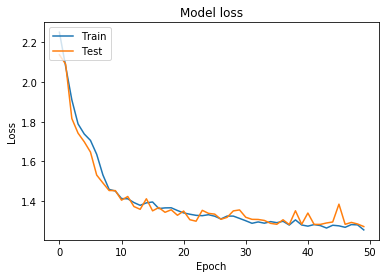

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 24us/step - loss: 4.1118 - acc: 0.0991 - val_loss: 3.7772 - val_acc: 0.0980
Epoch 2/50
60000/60000 [==============================] - 1s 20us/step - loss: 3.7615 - acc: 0.0987 - val_loss: 3.7772 - val_acc: 0.0980
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 3.7615 - acc: 0.0987 - val_loss: 3.7772 - val_acc: 0.0980
Epoch 4/50
60000/60000 [==============================] - 1s 20us/step - loss: 3.7615 - acc: 0.0987 - val_loss: 3.7772 - val_acc: 0.0980
Epoch 5/50
60000/60000 [==============================] - 1s 21us/step - loss: 3.7615 - acc: 0.0987 - val_loss: 3.7772 - val_acc: 0.0980
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 3.7615 - acc: 0.0987 - val_loss: 3.7772 - val_acc: 0.0980
Epoch 7/50
60000/60000 [==============================] - 1s 21us/step - loss: 3.7615 - acc: 0.0987 - val_loss: 3.7772 - val_acc

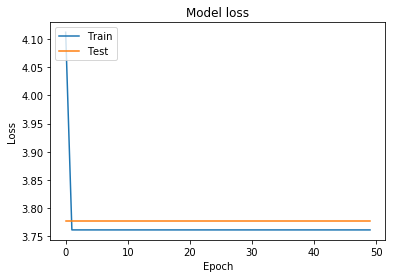

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 25us/step - loss: 4.9912 - acc: 0.0988 - val_loss: 3.5596 - val_acc: 0.0980
Epoch 2/50
60000/60000 [==============================] - 1s 20us/step - loss: 3.5302 - acc: 0.0987 - val_loss: 3.5482 - val_acc: 0.0980
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 3.5283 - acc: 0.0987 - val_loss: 3.5676 - val_acc: 0.0980
Epoch 4/50
60000/60000 [==============================] - 1s 20us/step - loss: 3.5277 - acc: 0.0987 - val_loss: 3.5333 - val_acc: 0.0980
Epoch 5/50
60000/60000 [==============================] - 1s 20us/step - loss: 3.5141 - acc: 0.0987 - val_loss: 3.5316 - val_acc: 0.0980
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 3.5113 - acc: 0.0987 - val_loss: 3.5275 - val_acc: 0.0980
Epoch 7/50
60000/60000 [==============================] - 1s 21us/step - loss: 3.5113 - acc: 0.0987 - val_loss: 3.5271 - val_acc

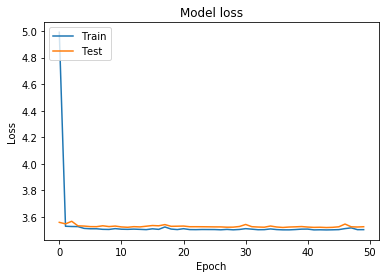

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 25us/step - loss: 2.3284 - acc: 0.1839 - val_loss: 2.1585 - val_acc: 0.2079
Epoch 2/50
60000/60000 [==============================] - 1s 20us/step - loss: 2.1236 - acc: 0.2317 - val_loss: 2.0865 - val_acc: 0.2681
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 2.0394 - acc: 0.2686 - val_loss: 2.0064 - val_acc: 0.2896
Epoch 4/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.9684 - acc: 0.2945 - val_loss: 1.9452 - val_acc: 0.3050
Epoch 5/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.9109 - acc: 0.3228 - val_loss: 1.8664 - val_acc: 0.3383
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.7920 - acc: 0.3621 - val_loss: 1.7352 - val_acc: 0.3680
Epoch 7/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.6923 - acc: 0.3880 - val_loss: 1.6590 - val_acc

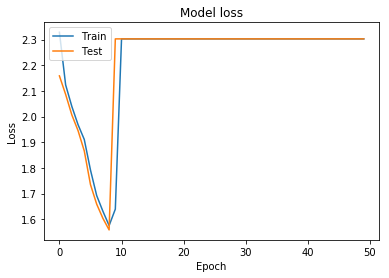

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 25us/step - loss: 2.2703 - acc: 0.1598 - val_loss: 2.0025 - val_acc: 0.2563
Epoch 2/50
60000/60000 [==============================] - 1s 20us/step - loss: 1.9699 - acc: 0.2591 - val_loss: 1.9296 - val_acc: 0.2548
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.8930 - acc: 0.2769 - val_loss: 1.8480 - val_acc: 0.3259
Epoch 4/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.7783 - acc: 0.3228 - val_loss: 1.7103 - val_acc: 0.3561
Epoch 5/50
60000/60000 [==============================] - 1s 20us/step - loss: 1.6633 - acc: 0.3273 - val_loss: 1.6499 - val_acc: 0.3466
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 1.5916 - acc: 0.3425 - val_loss: 1.6019 - val_acc: 0.3357
Epoch 7/50
60000/60000 [==============================] - 1s 21us/step - loss: 2.0363 - acc: 0.1893 - val_loss: 2.3026 - val_acc

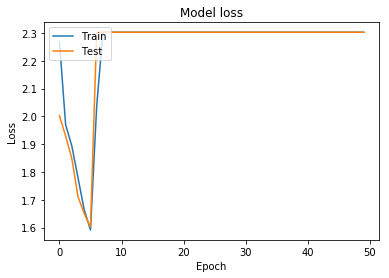

In [27]:
base_model=k_model(10,784)
lr = [0.01,0.05, 0.1, 0.001 , 0.005]
batch_size = [16,32,64,128]
for i in lr :
    base_model=k_model(10,784)
    base_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=i, momentum=0.0, nesterov=False),
                  metrics=['accuracy'])
    
 
    base_model = base_model.fit(x_train, y_train,
              batch_size=128,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
        
    loss(base_model)

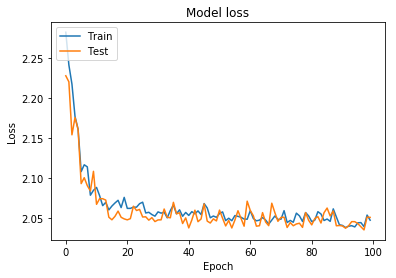

In [23]:
loss(base_model)

In [15]:
base_model.evaluate(x_train, y_train)

60000/60000 [==============================] - 2s 30us/step


[2.3025851249694824, 0.09871666666666666]

### Local SGD

Below is the list of variables:
1. Number of nodes
2. Learning rate
3. Time step
4. Data - Distributed/Not distributed

In [52]:
def list_model(n):
    l = []
    for i in range(n):
         l.append(k_model(10,784))
    
    return l

In [53]:
def define_model(n,alpha):
    models = list_model(n)
    

    num_batch = len(y_train) // batch_size

    #        c.append(0)
    #        loss.append([])

    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False, clipvalue=0.5),
                    metrics=['accuracy'])
    
    return models

In [49]:
def local_sgd(model,n,t,alpha,epoch,batch_size,train_data,test_data):
    
    '''
    This function performs local sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(model)
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
        
    # At present the loop is designed to handle only one layer in the network. Will be modified to accomodate any number of layers
    for i in range(epoch):
        weights = []
        c_prev = c
        
        # This loop runs as long as the subsequent updates in c causes it to increase. c becomes 0 whenever the epoch completes
        while (c_prev <= c):
            c_prev = c
            
            # After every t iteration averaging the gradients
            for j in range(t):
                for k in range(len(models)):
                    batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                    batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                    models[k].train_on_batch(batch_x, batch_y)
                    c += 1
                    c= c % num_batch

            # Obtaining the weights from each model
            for l in range(len(models)):
                weights.append(models[l].layers[0].get_weights())

            new_weight = weights[0]
            
            # Averaging the weights and assigning it to each model on the nodes
            for l in range(1,n):
                if l !=n-1:
                    new_layer=[j+k for j,k in zip(new_weight,weights[l])]
                else:
                    new_layer=[(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
            for l in range(len(models)):
                models[l].set_weights(new_weight)


        # Evalutaing the losses (train and test and appending it to the list)
        loss_tr = models[0].evaluate(train_data[0],train_data[1])
        loss_te = models[0].evaluate(test_data[0],test_data[1])
        print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
        train_loss.append(loss_tr[0])
        test_loss.append(loss_te[0])
    
    return (train_loss,test_loss)

In [51]:
model_parallel = k_model(10,784)
ans = local_sgd(model_parallel,4,10,0.00001,100,128,(x_train,y_train),(x_test,y_test))


10000/10000 [==============================] - 0s 37us/step
Epoch 0 of 100 : train loss - 8.351806299082439 : train accuracy - 0.06395 test loss - 8.3014134475708 test accuracy - 0.0621
10000/10000 [==============================] - 0s 37us/step
Epoch 1 of 100 : train loss - 7.931254096349081 : train accuracy - 0.06905 test loss - 7.840271913146973 test accuracy - 0.0673
10000/10000 [==============================] - 0s 39us/step
Epoch 2 of 100 : train loss - 7.5233100925445555 : train accuracy - 0.0741 test loss - 7.401221983337402 test accuracy - 0.0732
10000/10000 [==============================] - 0s 40us/step
Epoch 3 of 100 : train loss - 7.117314371109009 : train accuracy - 0.08003333333333333 test loss - 6.9878727905273434 test accuracy - 0.0826
10000/10000 [==============================] - 0s 37us/step
Epoch 4 of 100 : train loss - 6.766143521499634 : train accuracy - 0.08451666666666667 test loss - 6.61951416015625 test accuracy - 0.0897
10000/10000 [=========================

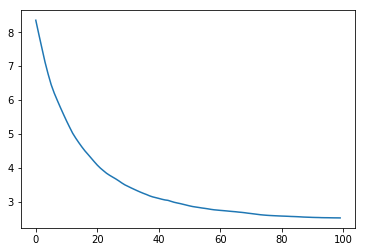

In [52]:
plt.plot(ans[0])